In [78]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

## Problem 1

#### (1)
$$
\sum_x \pi(x)A(x, y) = \sum_x \pi(y)A(y, x) = \pi(y)\sum_x A(y, x) = \pi(y)
$$
so $$\pi A = \pi$$

#### (2)
$$
\nu_i^TA\mu_j = \lambda_i\nu_i^T\mu_j
$$
$$
\nu_i^TA\mu_j = \nu_i^T\lambda_j\mu_j = \lambda_j\nu_i^T\mu_j
$$
so
$$
\lambda_i\nu_i^T\mu_j = \lambda_j\nu_i^T\mu_j
$$
Because $\lambda_i \neq \lambda_j$
$$
\nu_i^T\mu_j = 0
$$
and it's easy to see that
$$
\nu_i^T\mu_i \neq 0
$$
so with proper scale on $\mu, \nu$
$$
B^TC = I
$$

#### (3)
For any $f$, there must be coefficients $d_i$, so that
$$
f = \sum_{i=1}^n d_i\nu_i
$$
$$
\nu_1 = \pi
$$
We first prove that $d_1 = 1$.
Because
$$
\nu_i^TA = \lambda_i\nu_i^T
$$
we know
$$
\nu_i^T\mathbf{1} = \nu_i^TA\mathbf{1} = \lambda_i\nu_i^T\mathbf{1}
$$
for $i \neq 1$
$$
\nu_i^T\mathbf{1} = 0
$$
Because $f$ is a distribution, $f\mathbf{1} = 1$,
$$
d_1 = f\mathbf{1} = 1
$$
Therefore 
$$
\|fA^n-\pi\| = \|\sum_{i=2}^n d_i\lambda_i^n\nu_i\|_2 \leq \|\lambda_2\|^n\sqrt{\sum_{i=2}^n d_i}
$$

## Problem 2

$$
p(x|y) = \mathcal{N}(x|0.95y, 1-0.95^2)
$$
$$
p(y|x) = \mathcal{N}(y|0.95x, 1-0.95^2)
$$

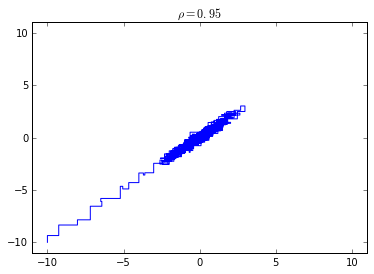

In [79]:
def cond_x_given_y(rho, y):
    return rho*y, np.sqrt(1 - rho**2)

def cond_y_given_x(rho, x):
    return rho*x, np.sqrt(1 - rho**2)

def problem_12_2(rho, jumps=100):
    x, y = -10., -10.
    trace = [(-10., -10.)]
    for jump in xrange(jumps):
        y_mu, y_sigma = cond_y_given_x(rho, x)
        y = np.random.normal(y_mu, y_sigma, size=1)
        trace.append((x, y))
        x_mu, x_sigma = cond_x_given_y(rho, y)
        x = np.random.normal(x_mu, x_sigma, size=1)
        trace.append((x, y))
    return trace

fig = plt.figure()
trace = problem_12_2(0.95, 600)
trace = np.array(trace)
ax = fig.add_subplot(1, 1, 1)
ax.plot(trace[:, 0], trace[:, 1])
ax.set_title(r'$\rho = %s$' % 0.95)
ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

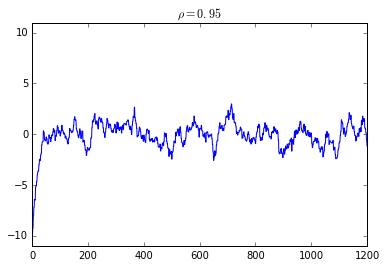

In [80]:
trace_x = trace[:, 0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(trace_x.shape[0]), trace_x)
ax.set_title(r'$\rho = %s$' % 0.95)
_ = ax.set_ylim(-11, 11)

In [81]:
def auto_correlation(a, t, var):
    a = np.array(a)
    n = a.shape[0]
    if n <= t:
        print 'lag too long'
        return 0
    elif t == 0:
        return 1.0
    vt = np.mean((a[t:] - a[:(-t)])**2)
    return 1. - vt/(2*var)

trace_x_split = trace_x[601:]
n = trace_x_split.shape[0]
rho_ts = np.array([auto_correlation(trace_x_split, t, 1.) for t in xrange(1, n)])
rho_ind = rho_ts[:(n-2)] + rho_ts[1:]
rho_max = np.where(rho_ind < 0)[0][0] + 1
rho_sum_est = np.sum(rho_ts[:rho_max])
print 'Sum of auto-correlations:', rho_sum_est
r_eff = 1. / (1 + 2*rho_sum_est)
print 'Relative efficiency:', r_eff

Sum of auto-correlations: 14.3264419313
Relative efficiency: 0.0337235327475


## Problem 3 

We simulate 500 samples from $t_3(5, 3^2)$

#### (a)

Posterior mean: [ 5.43396983  8.49644091]


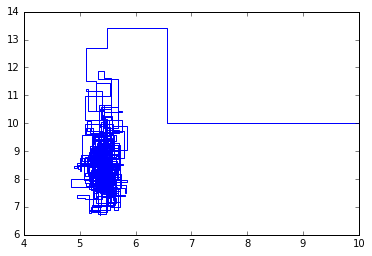

In [82]:
def inv_chi2(nu, sigma2, size=None):
    return stats.invgamma.rvs(nu / 2., scale=nu / 2. * sigma2, size=size)

def sample_vi(mu, sigma2, nu, yi):
    return inv_chi2(nu + 1., (nu*sigma2 + (yi - mu)**2)/(nu + 1.))

def sample_mu(v, sigma2, nu, y):
    return np.random.normal(np.sum(y / v) / np.sum(1. / v),
                            np.sqrt(1. / np.sum(1. / v)))

def sample_sigma2(mu, v, nu, y):
    n = y.shape[0]
    return np.random.gamma(n*nu / 2., 1. / (nu / 2. * np.sum(1. / v)))

def problem_12_3a(nu, y, jumps=100):
    mu = 10.
    sigma2 = 10.
    trace = [[10., 10.]]
    for jump in xrange(jumps):
        v = np.array([sample_vi(mu, sigma2, nu, y[i]) for i in xrange(y.shape[0])])
        mu = sample_mu(v, sigma2, nu, y)
        trace.append([mu, sigma2])
        sigma2 = sample_sigma2(mu, v, nu, y)
        trace.append([mu, sigma2])
    return trace

nu = 3
y = np.random.standard_t(nu, size=500)*3. + 5.
fig = plt.figure()
trace = problem_12_3a(nu, y, jumps=500)
trace = np.array(trace)
print 'Posterior mean:', trace.mean(axis=0)
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(trace[:, 0], trace[:, 1])

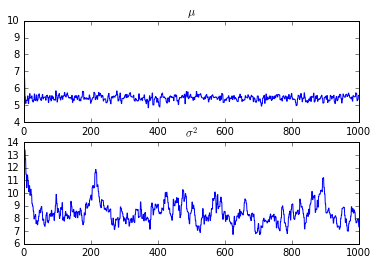

In [83]:
trace_mu = trace[:, 0]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(trace_mu.shape[0]), trace_mu)
_ = ax.set_title(r'$\mu$')

trace_sigma2 = trace[:, 1]
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(trace_sigma2.shape[0]), trace_sigma2)
_ = ax.set_title(r'$\sigma^2$')

#### (b)

Posterior mean: [4.88325652229494, 9.7026443902251813]


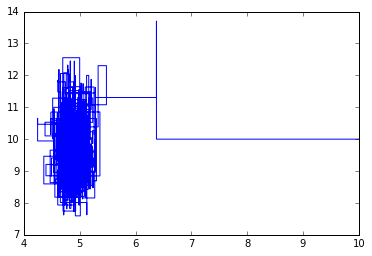

In [84]:
def sample_ui(mu, tau2, nu, yi, alpha2):
    return inv_chi2(nu + 1., (nu*tau2 + (yi - mu)**2 / alpha2)/(nu + 1.))

def sample_mu(u, tau2, nu, y, alpha2):
    return np.random.normal(np.sum(y / (alpha2 * u)) / np.sum(1. / (alpha2 * u)),
                            np.sqrt(1. / np.sum(1. / (alpha2 * u))))

def sample_tau2(mu, u, nu, y, alpha2):
    n = y.shape[0]
    return np.random.gamma(n*nu / 2., 1. / (nu / 2. * np.sum(1. / u)))

def sample_alpha2(mu, tau2, u, nu, y):
    n = y.shape[0]
    return inv_chi2(n, np.mean((y - mu)**2 / u))

def problem_12_3b(nu, y, jumps=100):
    mu = 10.
    tau2 = 10.
    alpha2 = 1.
    trace = [[10., 10., 1.]]
    for jump in xrange(jumps):
        u = np.array([sample_ui(mu, tau2, nu, y[i], alpha2)
                      for i in xrange(y.shape[0])])
        mu = sample_mu(u, tau2, nu, y, alpha2)
        trace.append([mu, tau2, alpha2])
        tau2 = sample_tau2(mu, u, nu, y, alpha2)
        trace.append([mu, tau2, alpha2])
        alpha2 = sample_alpha2(mu, tau2, u, nu, y)
        trace.append([mu, tau2, alpha2])
    return trace

nu = 3
y = np.random.standard_t(nu, size=500)*3. + 5.
fig = plt.figure()
trace = problem_12_3b(nu, y, jumps=500)
trace = np.array(trace)
mu_mean = trace[:, 0].mean(axis=0)
sigma_mean = (trace[:, 1]*trace[:, 2]).mean()
print 'Posterior mean:', [mu_mean, sigma_mean]
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(trace[:, 0], trace[:, 1]*trace[:, 2])

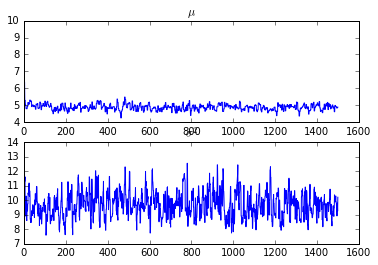

In [85]:
trace_mu = trace[:, 0]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(trace_mu.shape[0]), trace_mu)
_ = ax.set_title(r'$\mu$')

trace_sigma2 = trace[:, 1]*trace[:, 2]
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(trace_sigma2.shape[0]), trace_sigma2)
_ = ax.set_title(r'$\sigma^2$')

We can see that the second approach converges much faster and explore the sigma space more quickly.